그래프 데이터를 활용한 금융 사기 거래 탐지 및 예방

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from itertools import groupby
import networkx as nx
from community import community_louvain
import matplotlib.patches as mpatches
from concurrent.futures import ThreadPoolExecutor, as_completed
from faker import Faker
from itertools import groupby


In [2]:
fake = Faker()
start_date = datetime(2024, 5, 1)
num_days = 15
num_users = 3000
transactions_per_user = 5  # 사기 사용자의 최대 거래 횟수

# 사용자 정보 초기화
users = pd.DataFrame({
    'user_id': range(num_users),
    'ip': [fake.ipv4() for _ in range(num_users)],
    'device_id': [fake.uuid4() for _ in range(num_users)],
    'phone_number': [fake.phone_number() for _ in range(num_users)],
    'credit_card': [fake.credit_card_number() for _ in range(num_users)],
})

# 사기 그룹 설정
fraud_group_size = 30
ip_fraud_users = set(np.random.choice(num_users, fraud_group_size, replace=False))
card_fraud_users = set(np.random.choice(num_users, fraud_group_size, replace=False))
device_phone_fraud_users = set(np.random.choice(num_users, fraud_group_size, replace=False))

# 사기 사용자들이 공유할 값 정의
shared_ips = [fake.ipv4() for _ in range(10)]  # 사기 사용자들이 공유하는 IP 주소
shared_cards = [fake.credit_card_number() for _ in range(10)]  # 공유 신용카드 번호
shared_devices = [fake.uuid4() for _ in range(10)]  # 공유 디바이스 ID
shared_phones = [fake.phone_number() for _ in range(10)]  # 공유 전화번호

# 거래 데이터 생성
transactions = []
for user_id in range(num_users):
    num_transactions = np.random.randint(1, transactions_per_user + 1) if user_id in ip_fraud_users or user_id in card_fraud_users or user_id in device_phone_fraud_users else 5
    for _ in range(num_transactions):
        day = np.random.choice(num_days)
        date = start_date + timedelta(days=day)
        ip = shared_ips[np.random.randint(len(shared_ips))] if user_id in ip_fraud_users else users.at[user_id, 'ip']
        card = shared_cards[np.random.randint(len(shared_cards))] if user_id in card_fraud_users else users.at[user_id, 'credit_card']
        device = shared_devices[np.random.randint(len(shared_devices))] if user_id in device_phone_fraud_users else users.at[user_id, 'device_id']
        phone = shared_phones[np.random.randint(len(shared_phones))] if user_id in device_phone_fraud_users else users.at[user_id, 'phone_number']
        is_fraud = user_id in ip_fraud_users or user_id in card_fraud_users or user_id in device_phone_fraud_users
        transactions.append({
            'transaction_id': fake.uuid4(),
            'user_id': user_id,
            'transaction_time': date,
            'ip': ip,
            'device_id': device,
            'phone_number': phone,
            'credit_card_number': card,
            'order_item': np.random.choice(['스마트폰', '노트북', '식품', '문구', '악세서리','가전제품', '의류', '화장품', '아동용품', '여행용품']),
            'amount': np.random.randint(1000, 300000),
            'is_fraud': is_fraud
        })

transactions_df = pd.DataFrame(transactions)

In [8]:
print(transactions_df)

                             transaction_id  user_id transaction_time  \
0      75c43e4a-4f78-4271-9b5f-66e00c1ab295        0       2024-05-12   
1      216ec138-3d54-4654-8234-6d9c0c8a42ab        0       2024-05-05   
2      98271825-2d6f-4cad-81eb-2d9a4afdb763        0       2024-05-02   
3      057fb0ca-7616-4bce-8bad-b8845f5fdf4c        0       2024-05-14   
4      0fa8f573-7b34-49b9-b247-85f0f28c9090        0       2024-05-10   
...                                     ...      ...              ...   
14810  797b7ef3-7840-49d5-afdc-8192f2c50a24     2999       2024-05-10   
14811  ac3d5641-c0b3-4527-978a-f31f297a8f87     2999       2024-05-05   
14812  91b395c2-28d6-4e9c-a8ed-3e91fa203518     2999       2024-05-03   
14813  3c2ef07e-1d3f-43dc-b338-b0b8d3d581e9     2999       2024-05-13   
14814  9eca0deb-0e7d-4367-a05b-f4951d289f36     2999       2024-05-08   

                  ip                             device_id  \
0      57.166.51.189  3af73b13-9565-45fa-a6e4-e97975b92bc1   

build_graph 함수 정의

In [9]:
def build_graph(data):
    G = nx.Graph()
    for _, row in data.iterrows():
        G.add_edge(row['user_id'], row['ip'], weight=1)
        G.add_edge(row['user_id'], row['device_id'], weight=1)
        G.add_edge(row['user_id'], row['credit_card_number'], weight=1)
        G.add_edge(row['user_id'], row['phone_number'], weight=1)
        
        # 노드 속성 설정
        G.nodes[row['user_id']]['node_type'] = 'user_id'
        G.nodes[row['ip']]['node_type'] = 'ip'
        G.nodes[row['device_id']]['node_type'] = 'device_id'
        G.nodes[row['credit_card_number']]['node_type'] = 'credit_card'
        G.nodes[row['phone_number']]['node_type'] = 'phone_number'
    return G

G = build_graph(transactions_df)



In [10]:
partition = community_louvain.best_partition(G)
for node, comm_id in partition.items():
    G.nodes[node]['community'] = comm_id
    
all_communities = [list(group) for key, group in groupby(sorted(partition, key=partition.get), key=partition.get)]

### 네트워크 그래프에서 식별된 커뮤니티 분석 함수

analyze_community 함수는 주어진 커뮤니티의 노드들을 이용해 서브그래프 생성, 서브 그래프의 밀도와 모듈성 계산. 

analyze_communities_parallel 함수는 커뮤니티 분석을 병렬로 실행, 전체적인 처리 속도를 향상시킴. 

In [12]:
def analyze_community(G, nodes):
    subgraph = G.subgraph(nodes)
    comm_density = nx.density(subgraph)
    modularity_score = community_louvain.modularity(partition, G)
    user_count = sum(1 for node in nodes if G.nodes[node]['node_type'] == 'user_id')
    phone_count = sum(1 for node in nodes if G.nodes[node]['node_type'] == 'phone_number')
    card_count = sum(1 for node in nodes if G.nodes[node]['node_type'] == 'credit_card')
    return [comm_density, modularity_score, len(nodes), user_count, phone_count, card_count]

def analyze_communities_parallel(G, all_communities):
    community_info = []
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(analyze_community, G, nodes): comm_id for comm_id, nodes in enumerate(all_communities)}
        for future in as_completed(futures):
            comm_id = futures[future]
            result = future.result()
            community_info.append([comm_id] + result)
    return pd.DataFrame(community_info, columns=['Community ID', 'Density', 'Modularity', 'Size', 'User Count', 'Phone Count', 'Card Count'])

df_community = analyze_communities_parallel(G, all_communities)

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


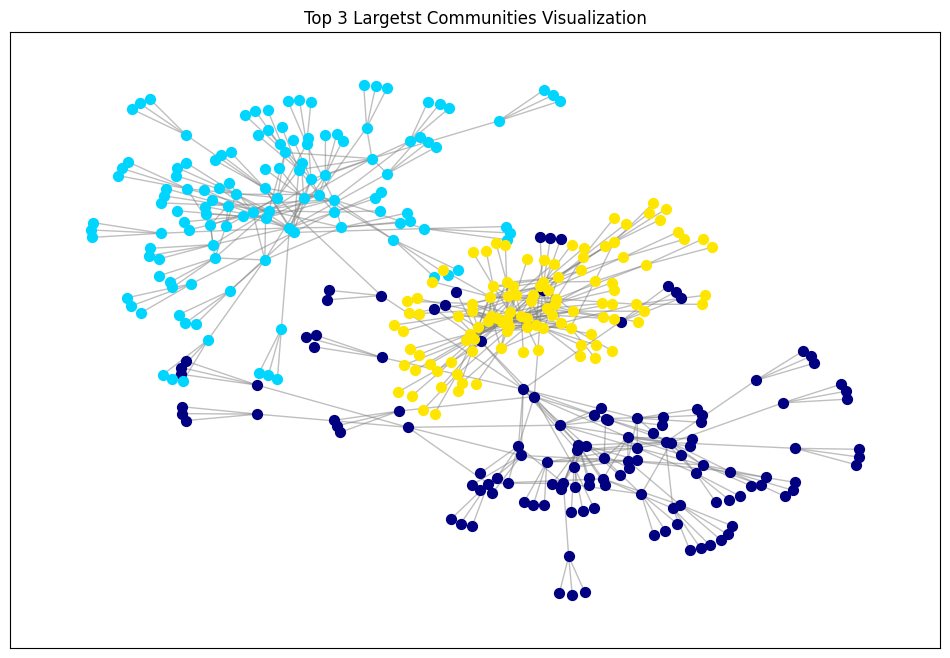

In [13]:
# 가장 큰 세 개의 커뮤니티 선택
top_communities = sorted(all_communities, key=len, reverse=True)[:3]
filtered_nodes = [node for comm in top_communities for node in comm]
G_top = G.subgraph(filtered_nodes)

# 시각화
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_top)
for comm_id, nodes in enumerate(top_communities):
    nx.draw_networkx_nodes(G_top, pos, nodelist=nodes, node_size=50, node_color=plt.cm.jet(comm_id / len(top_communities)))
nx.draw_networkx_edges(G_top, pos, alpha=0.5, edge_color='gray')
plt.title("Top 3 Largetst Communities Visualization")
plt.show()

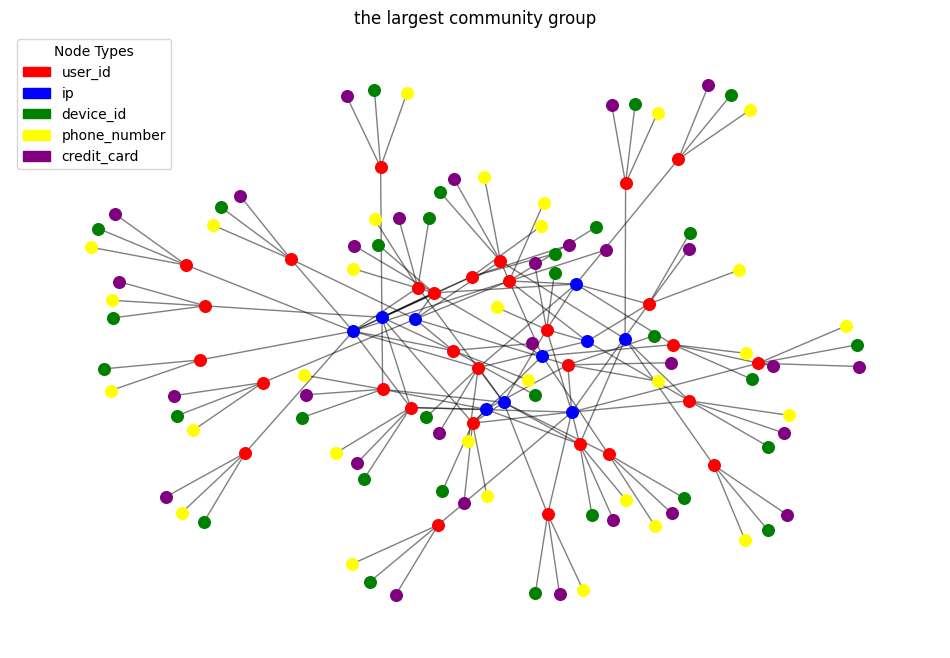

In [14]:
# 가장 큰 커뮤니티 추출
largest_community = max(all_communities, key=len)
G_largest = G.subgraph(largest_community)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G_largest)

# 노드 유형별 색상 지정
node_types = {
    'user_id' : 'red',
    'ip' : 'blue',
    'device_id' : 'green',
    'phone_number' : 'yellow',
    'credit_card' : 'purple'
}

# 노드 그리기
for node_type, color in node_types.items():
    nx.draw_networkx_nodes(G_largest, pos, nodelist=[n for n in G_largest if G_largest.nodes[n]['node_type'] == node_type],
                           node_color = color,
                           node_size=70,
                           label=node_type)
    
nx.draw_networkx_edges(G_largest, pos, alpha=0.5)

# 범례
patches = [mpatches.Patch(color = color, label=node_type) for node_type, color in node_types.items()]
plt.legend(handles=patches, title="Node Types", loc='upper left')

plt.title("the largest community group")
plt.axis('off')
plt.show()